# Statistical Methods for Machine Learning project

In [5]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr

random.seed(42)
npr.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.enabled = False

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [15]:
import kagglehub
import shutil

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")
shutil.rmtree(os.path.join(path, 'rps-cv-images'))

print("Path to dataset files:", path)

Path to dataset files: /home/prometheus/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


a
MhOAtto6kcc8xsKr.png


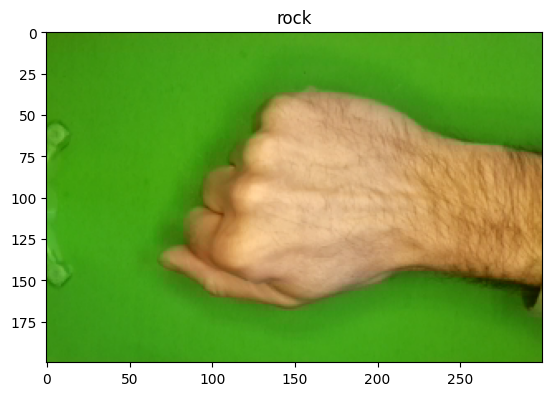

In [16]:
plt.figure()
print(random.choice(['a','b','c']))
folder = os.path.join(path, random.choice(['rock','paper','scissors']))
img_name = random.choice(os.listdir(folder))
print(img_name)
plt.imshow(io.imread(os.path.join(folder,img_name)))
plt.title('rock')
plt.show()

# Transformation and data augmentation

# DataLoader creation

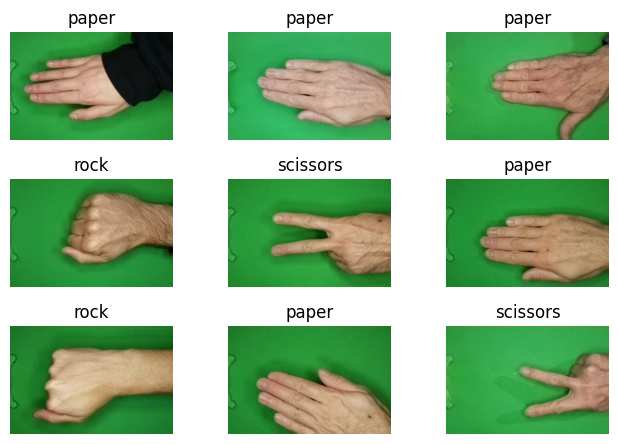

In [24]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=path, transform=transform)
dl = DataLoader(dataset, batch_size=9, shuffle=True)

for img,lbl in dl:
    for i in range(len(img)):
        ax = plt.subplot(3,3,i+1)
        plt.tight_layout()
        ax.set_title(dataset.classes[lbl[i]])
        ax.axis('off')
        plt.imshow(img[i].permute(1,2,0))
    break
plt.show()

# SomeNet

In [26]:
class SomeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        #2D convolution with 3 input channels, 16 output channels, and 5x5 filters
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.norm1 = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(6,16,3)
        self.middleconv2 = nn.Conv2d(16,16,3)
        self.norm2 = nn.BatchNorm2d(16)

        self.conv3 = nn.conv2d(16,64,3)
        self.norm3 = nn.batchNorm2d(64)

        self.conv4 = nn.conv2d(64,120,3)
        self.middleconv4 = nn.Conv2d(120,120,3)
        self.norm4 = nn.BatchNorm2d(120)

        self.fc1 = nn.Linear(120*10*10,120)
        self.fc2 = nn.Linear(120,64)
        self.fc3 = nn.Linear(64,3)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = F.relu(self.norm2(self.conv2(x)))
        x = self.pool(F.relu(self.norm2(self.middleconv2(x))))
        x = self.pool(F.relu(self.norm3(self.conv3(x))))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.middleconv4(x)))

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x